In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Load the cleaned dataset, parsing 'datetime' and setting it as the index
df = pd.read_csv(
    'D:/Data science/energy-forecasting-ml/data/raw/UMass Smart Dataset/smartumass.csv',
    parse_dates=['time'],
    index_col='time'
)

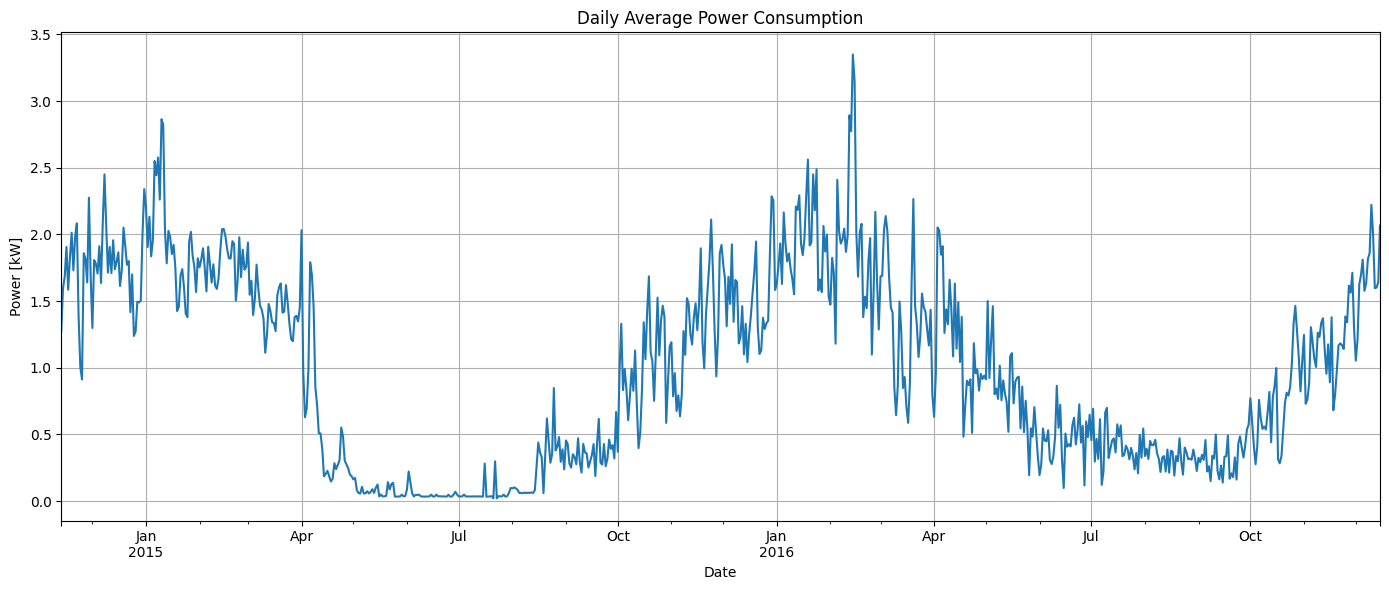

In [2]:


# Resample hourly consumption data to daily average
daily_power = df['power [kW]'].resample('D').mean()

# Create the plot
plt.figure(figsize=(14, 6))
daily_power.plot()
plt.title('Daily Average Power Consumption')
plt.xlabel('Date')
plt.ylabel('Power [kW]')
plt.grid(True)
plt.tight_layout()
plt.show()


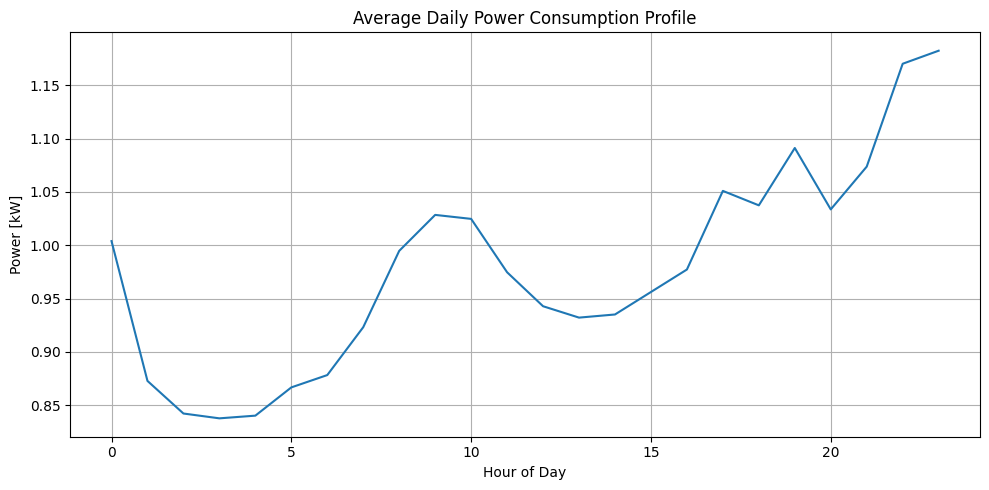

In [3]:
# Extract the hour and compute the average daily profile
df['hour'] = df.index.hour
avg_profile = df.groupby('hour')['power [kW]'].mean()

# Create the plot
plt.figure(figsize=(10, 5))
avg_profile.plot()
plt.title('Average Daily Power Consumption Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Power [kW]')
plt.grid(True)
plt.tight_layout()
plt.show()



<Figure size 1400x600 with 0 Axes>

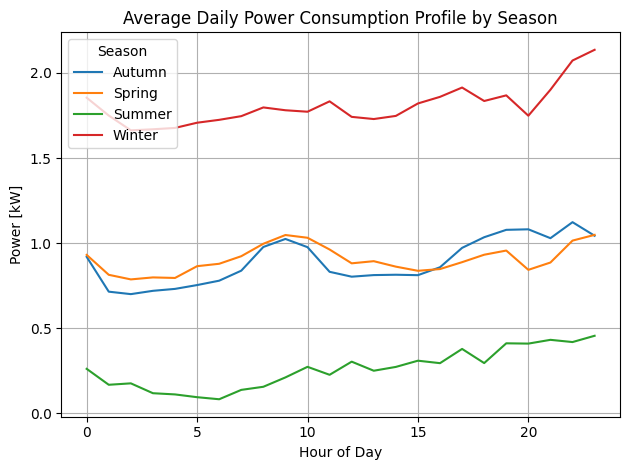

In [4]:
df['hour'] = df.index.hour
df['month'] = df.index.month

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

# Compute the average power consumption by hour and season
grouped = df.groupby(['season', 'hour'])['power [kW]'].mean().reset_index()
seasonal_profile = grouped.pivot(index='hour', columns='season', values='power [kW]')

# Plot seasonal profiles
plt.figure(figsize=(14, 6))
seasonal_profile.plot()
plt.title('Average Daily Power Consumption Profile by Season')
plt.xlabel('Hour of Day')
plt.ylabel('Power [kW]')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Season', loc='upper left')
plt.show()


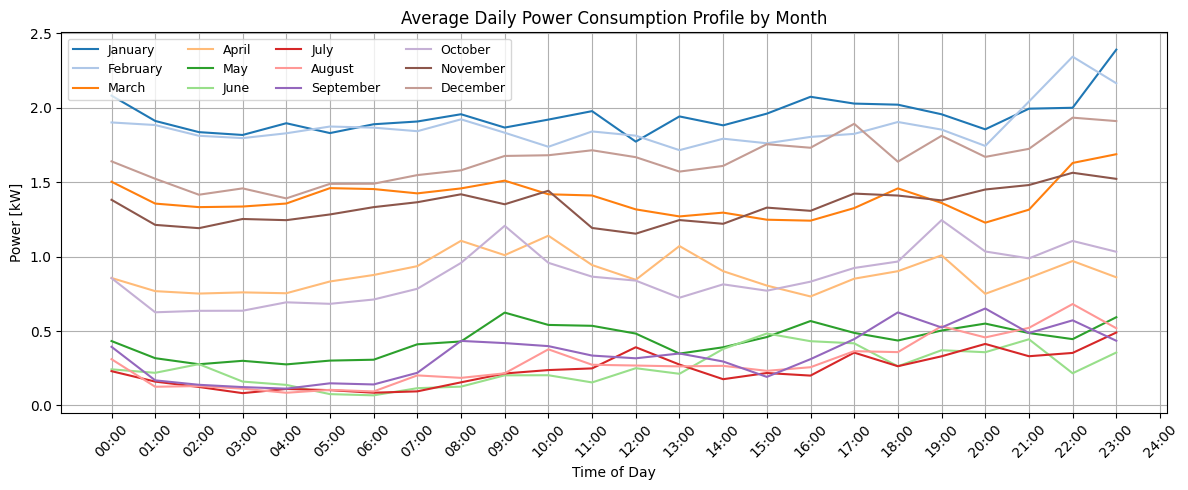

In [5]:

colors = plt.get_cmap('tab20').colors

plt.figure(figsize=(12, 5))

# Loop through all 12 months
for month in range(1, 13):
    # Filter data for the current month
    month_data = df[df.index.month == month]
    
    # Compute average load profile per time of day
    # Group by time (datetime.time) for detailed resolution
    daily_profile = month_data.groupby(month_data.index.time)['power [kW]'].mean()
    
    # Convert times to minutes since midnight
    times_as_minutes = [t.hour * 60 + t.minute for t in daily_profile.index]
    
    # Plot with the full English month name as label
    plt.plot(times_as_minutes, daily_profile.values,
             label=calendar.month_name[month],
             color=colors[month - 1])  # 0-indexed

# Customize plot
plt.title('Average Daily Power Consumption Profile by Month')
plt.xlabel('Time of Day')
plt.ylabel('Power [kW]')
plt.grid(True)

# Set x-ticks to display every hour
ticks = list(range(0, 24 * 60 + 1, 60))
labels = [f'{h:02}:00' for h in range(25)]
plt.xticks(ticks, labels, rotation=45)

# Show legend with month names
plt.legend(ncol=4, fontsize=9)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

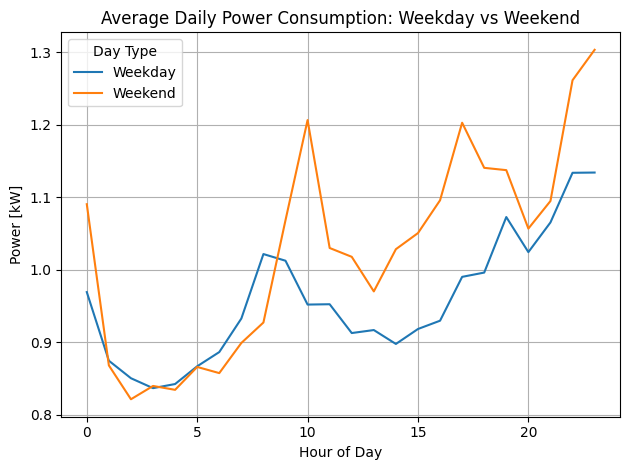

In [6]:

df['hour'] = df.index.hour
df['weekday'] = df.index.weekday  # 0=Monday,...,6=Sunday

# Classify as Weekday or Weekend
df['week_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Compute the average consumption by hour and day type
grouped = df.groupby(['week_type', 'hour'])['power [kW]'].mean().reset_index()
profile_week = grouped.pivot(index='hour', columns='week_type', values='power [kW]')

# Plot the profiles
plt.figure(figsize=(12, 6))
profile_week.plot()
plt.title('Average Daily Power Consumption: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Power [kW]')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Day Type')
plt.show()


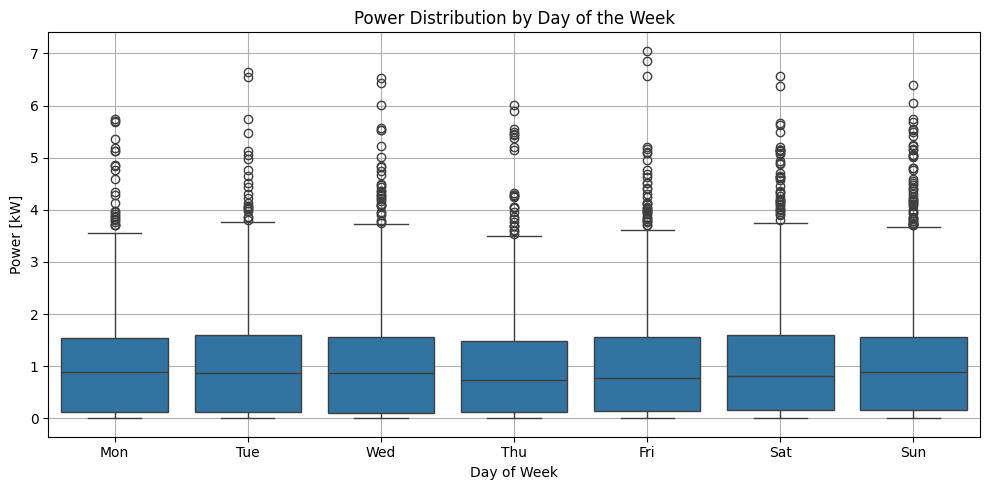

In [7]:
# Add 'weekday' and 'hour' columns
df['weekday'] = df.index.weekday  # 0=Mon,..6=Sun
df['hour'] = df.index.hour

# 1) Boxplot by day of the week
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='weekday', y='power [kW]')
plt.title('Power Distribution by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Power [kW]')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.tight_layout()
plt.show()


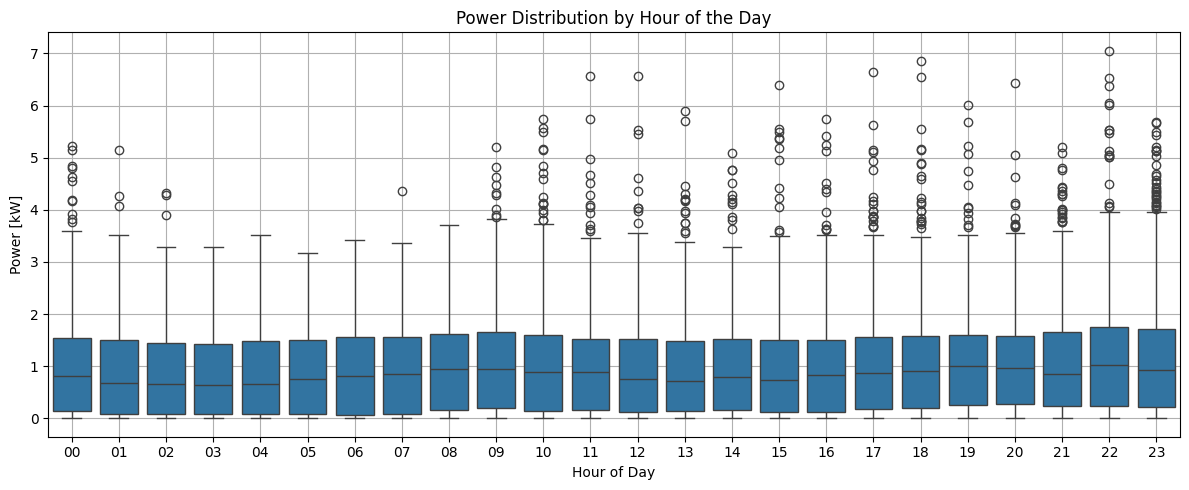

In [8]:
# 2) Boxplot by hour of the day
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='hour', y='power [kW]')
plt.title('Power Distribution by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Power [kW]')
plt.xticks(ticks=range(24), labels=[f'{h:02d}' for h in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()


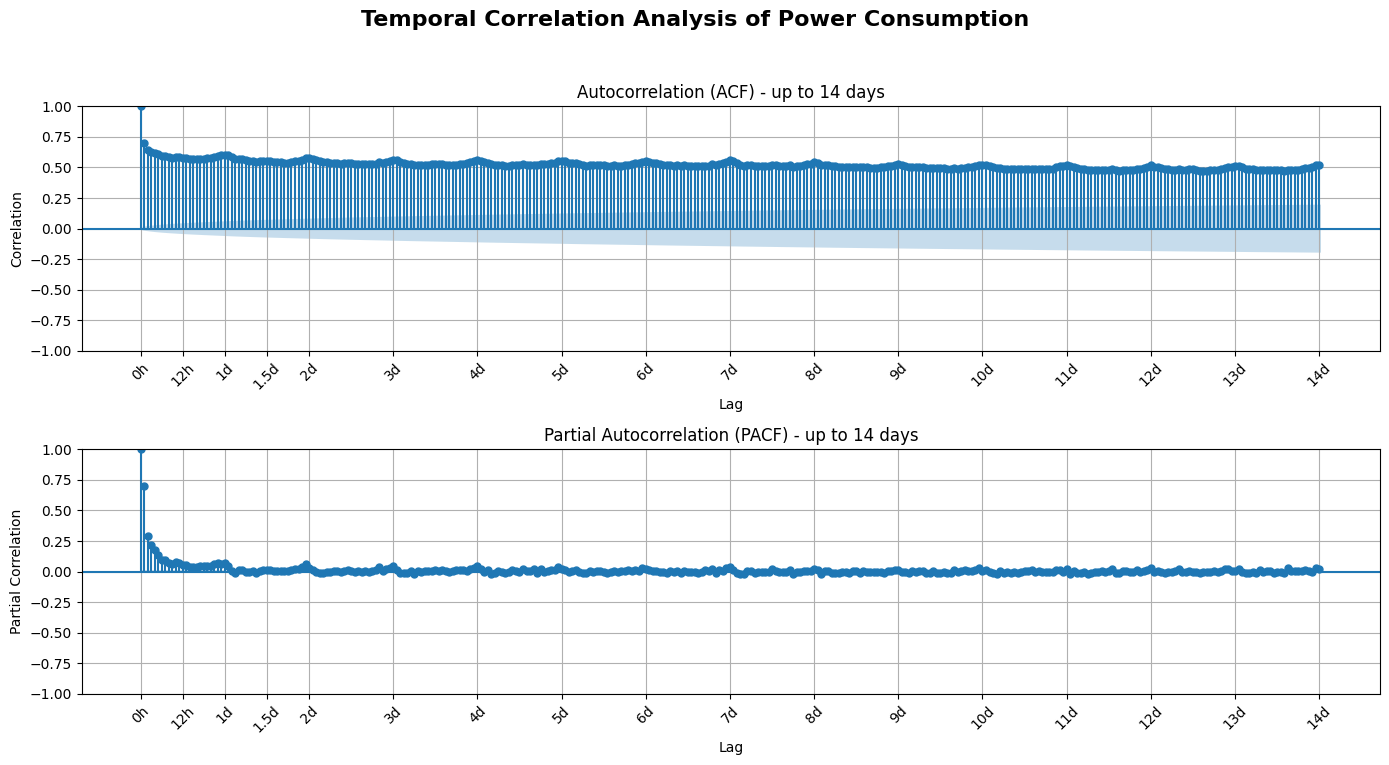

In [9]:
# Hourly time series
series = df['power [kW]']

# Set up the figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=100)

# Number of lags: 24 lags per day × 14 days = 336
max_lag = 24 * 14

# Define tick positions and labels: 0h, 12h, 1d, 1.5d, ..., 14d
ticks = [0, 12, 24, 36, 48] + [24 * i for i in range(3, 15)]
labels = ['0h', '12h', '1d', '1.5d', '2d'] + [f'{i}d' for i in range(3, 15)]

# ACF
plot_acf(series, lags=max_lag, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation (ACF) - up to 14 days')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels, rotation=45)
axes[0].grid(True)

# PACF
plot_pacf(series, lags=max_lag, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF) - up to 14 days')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Correlation')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(labels, rotation=45)
axes[1].grid(True)

# Global title and layout
plt.suptitle('Temporal Correlation Analysis of Power Consumption', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


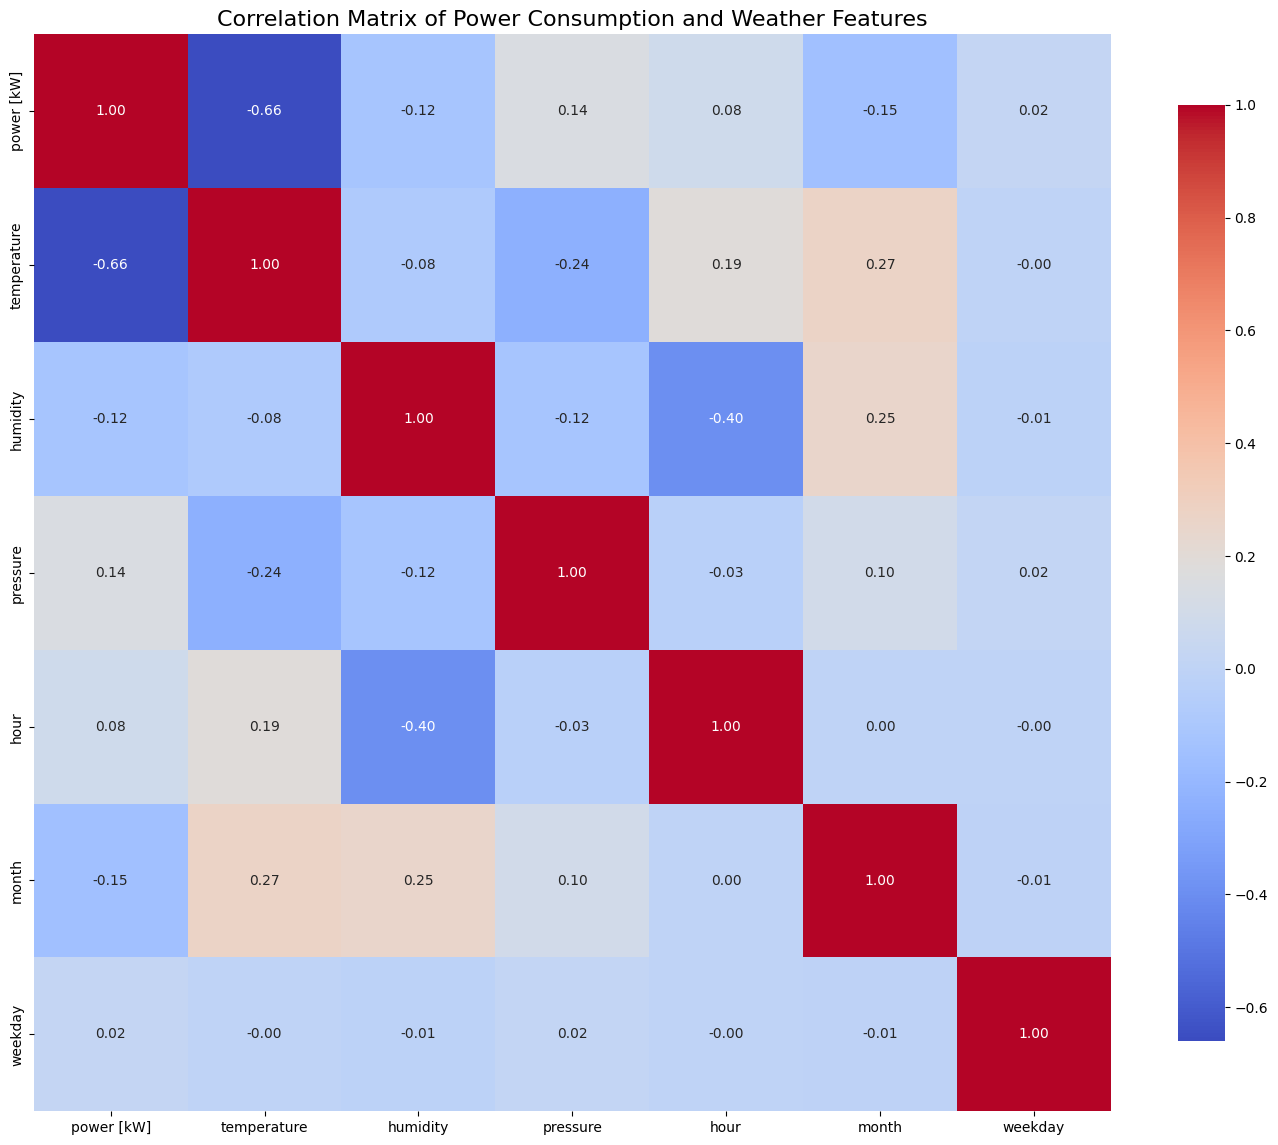

In [10]:
# 2. One-hot encode the 'icon' column
df_enc = pd.get_dummies(df, columns=['icon'], prefix='icon', drop_first=False)

# 3. Explicitly select the columns to include in the correlation
#    - 'power [kW]' first
#    - all dummy-encoded icons
#    - then other numerical weather features
cols = ['power [kW]'] \
     + ['temperature', 'humidity', 'pressure',
        'hour', 'month', 'weekday']  # adjust according to your columns

# 4. Compute the correlation matrix for this subset
corr = df_enc[cols].corr()

# 5. Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': .8}
)
plt.title("Correlation Matrix of Power Consumption and Weather Features", fontsize=16)
plt.tight_layout()
plt.show()
